# Plot Data of Environmental Network within ROMY

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from pandas import DataFrame
from obspy import UTCDateTime, Stream

In [2]:
# sys.path.append('..')

In [3]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals
from functions.read_sds import __read_sds
from functions.load_furt_stream import __load_furt_stream
from functions.read_wromy_data import __read_wromy_data
from functions.find_labels import __find_lables
from functions.smoothing import __smooth

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'teide':
    root_path = '/home/sysopromy/'
    data_path = '/freenas-ffb-01/'
    archive_path = '/freenas-ffb-01/'
    bay_path = '/bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def __find_min_max_stream(_st, _cha):

    from numpy import nanmin, nanmax, nanpercentile

    arr = []
    for tr in _st:
        if tr.stats.channel == _cha:
            arr.append(tr.data)

    return nanpercentile(arr, 0.05), nanpercentile(arr, 99.95)

In [7]:
def __find_min_max(_df, _cha):

    from numpy import nanpercentile, array, append

    arr = array([])
    for _k in _df.keys():
        arr = append(arr, array(_df[_k][_cha]))

    return nanpercentile(arr, 0.05), nanpercentile(arr, 99.95)

In [8]:
config = {}

# define path to data
config['path_to_sds'] = archive_path+"romy_archive/"

# path to figure output
config['path_to_figs'] = archive_path+f"romy_html_monitor/figures/"

# specify length of time interval to show
config['time_interval'] = 14 # days

# define time interval
config['tend'] = UTCDateTime().now()
config['tbeg'] = config['tend'] - config['time_interval'] * 86400


# specify wromy stations to use
config['wromy_stations'] = [1, 4, 5, 6, 7, 8, 9]

# specify promy stations to use
config['promy_stations'] = [] # [1, 4, 5, 7, 9]

# specify colors for stations
config['colors'] = {
                    1: 'darkgreen',
                    3: 'lightgreen',
                    4: 'purple',
                    5: 'darkred',
                    6: 'darkblue',
                    7: 'darkorange',
                    8: 'darkcyan',
                    9: 'cyan',
                    }

### Load Maintenance Log

In [9]:
try:
    # load log file
    lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

    # get intervals of maintenance work as utc times
    lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

except Exception as e:
    print(e)
    print(f" -> failed to load maintenance log")


### Load WROMY data

In [10]:
# ws = Stream()

# for _s in config['wromy_stations']:
#     try:
#         ws += __read_sds(archive_path+"temp_archive/", f"BW.WROMY.0{_s}.L*I", config['tbeg'], config['tend'])
#     except:
#         print(f" -> failed to load WS: {_s}")

# ws = ws.merge();

# ws

In [11]:
def __get_dummy(xdate, dt=1):

    from pandas import DataFrame, read_csv, concat, date_range
    from numpy import nan
    from obspy import UTCDateTime

    df_dummy = DataFrame()

    xdate_utc = UTCDateTime(xdate)

    df_dummy['Seconds'] = np.arange(0, 86400, dt).astype(int)
    df_dummy['Date'] = int(xdate)
    df_dummy['Time (UTC)'] = [int(str((xdate_utc + _t).time()).replace(':', '')) for _t in df_dummy.Seconds]
    df_dummy['Temperature (°C)'] = nan
    df_dummy['Pressure (hPa)'] = nan
    df_dummy['rel. Humidity (%)'] = nan

    return df_dummy

In [12]:
def __read_wromy_data(t1, t2, cha, path_to_data):

    from os import path
    from pandas import DataFrame, read_csv, concat, date_range
    from numpy import nan
    from obspy import UTCDateTime

    t1, t2 = UTCDateTime(t1), UTCDateTime(t2)

    df = DataFrame()

    for n, dat in enumerate(date_range(t1.date, t2.date)):

        doy = str(UTCDateTime(dat).julday).rjust(3, "0")
        year = UTCDateTime(dat).year

        datapath = f"{path_to_data}{year}/BW/WROMY/{cha}.D/"

        if not path.isdir(datapath):
            print(f" -> Path: {datapath}, does not exists!")
            return

        try:
            filename = f'BW.WROMY.{cha}.D.{year}.{doy}'

            try:
                df0 = read_csv(datapath+filename)
                # replace error indicating values (-9999, 999.9) with NaN values
                df0.replace(to_replace=-9999, value=nan, inplace=True)
                df0.replace(to_replace=999.9, value=nan, inplace=True)

            except:
                df0 = __get_dummy(UTCDateTime(dat).replace('-', ''), dt=1)

            if n == 0:
                df = df0
            else:
                try:
                    df = concat([df, df0])
                except:
                    df = concat([df, __get_dummy(UTCDateTime(dat).replace('-', ''), dt=1)])

        except:
            print(f" -> file: {filename}, does not exists!")

    df.reset_index(inplace=True, drop=True)

    # add columns with total seconds
    if 'Seconds' in df.columns:
        totalSeconds = df.Seconds + (df.Date - df.Date.iloc[0]) * 86400
        df['totalSeconds'] = totalSeconds

    return df

In [13]:
ws = {}

for _s in config['wromy_stations']:

    try:
        _ws = __read_wromy_data(config['tbeg'], config['tend'], f"WS{_s}", archive_path+"romy_archive/")

        last_value_t = 0
        last_value_d = str(config['tbeg'].date).replace("-", "")
        _datetime_str = []
        for _d, _t in zip(_ws['Date'], _ws['Time (UTC)']):
            try:
                t = int(_t)
                d = str(_d)
            except:
                t = int(last_value_t + 1)
                d = str(last_value_d)
            finally:
                last_value_t = t
                last_value_d = d
            try:
                _datetime_str.append(f"{d[0:4]}-{d[4:6]}-{d[6:8]}T{str(t).rjust(6, '0')}")
            except:
                pass

        _ws_times_utc = [UTCDateTime(_dt) for _dt in _datetime_str]

        ws[_s] = {"time": np.array(_ws_times_utc),
                  "LKI": np.array(_ws['Temperature (°C)']),
                  "LDI": np.array(_ws['Pressure (hPa)']),
                  "LII": np.array(_ws['rel. Humidity (%)']),
                 }

    except Exception as e:
        print(e)
        print(f" -> failed to load WS: {_s}")


### Load PROMY data

In [14]:
# ps = Stream()

# for _s in config['promy_stations']:
#     try:
#         ps += __read_sds(archive_path+"temp_archive/", f"BW.PROMY.0{_s}.L*I", config['tbeg'], config['tend'])
#     except Exception as e:
#         print(e)
#         print(f" -> failed to load PS: {_s}")

# ps3 = ps.merge();

# ps

### Load FURT data

In [15]:
try:
    furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')
except Exception as e:
    print(e)
    print(f" -> failed to load FURT data")


Specified end: 2025-03-24T16:56:25.143502Z 
Trace end:     2025-03-24T16:56:26.000000Z


### Load Radon Data

In [16]:
try:
    rdn = __read_wromy_data(config['tbeg'], config['tend'], "RDN", archive_path+"romy_archive/")

    # add utc times
    rdn['times_utc'] = [UTCDateTime(f"{d}T{str(t).rjust(6, '0')}") for d, t in zip(rdn['Date'], rdn['Time (UTC)'])]

except Exception as e:
    print(e)
    print(f" -> failed to load radon data")


### Plotting

In [17]:
def __makeplot():

    import gc

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(8, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    try:
        axes0 = ax[0].twinx()
        axes0.plot(furt.select(channel="LAT")[0].times(reftime=config['tbeg']),
                   furt.select(channel="LAT")[0].data, color="grey", label="FURT",
                   zorder=1, alpha=0.6, lw=1
                  )

    except:
        pass

    axes0.tick_params(axis='y', colors="grey")
    axes0.set_ylabel("FURT (°C)", color="grey")

    try:
        ax[1].plot(furt.select(channel="LAP")[0].times(reftime=config['tbeg']),
                   furt.select(channel="LAP")[0].data, color="grey", label="FURT"
                  )
    except:
        pass

    try:
        axes2 = ax[2].twinx()
        axes2.plot(furt.select(channel="LAH")[0].times(reftime=config['tbeg']),
                   furt.select(channel="LAH")[0].data, color="grey", label="FURT",
                   zorder=1, alpha=0.6, lw=1
                  )
        axes2.set_ylim(0, 100)
    except:
        pass

    axes2.tick_params(axis='y', colors="grey")
    axes2.set_ylabel("FURT (%)", color="grey")

    for _s in config['wromy_stations']:

        # only plot temperature of PROMY if available
        if _s not in config['promy_stations']:
            ax[0].plot(ws[_s]['time'] - config['tbeg'],  __smooth(ws[_s]['LKI'], 3*3600),
                       color=config['colors'][_s], lw=1, label=f"WS{_s} (3hr)")

        try:
            ax[1].plot(ws[_s]['time'] - config['tbeg'], ws[_s]['LDI'],
                       color=config['colors'][_s], lw=1, label=f"WS{_s}")
        except:
            pass

        try:
            ax[2].plot(ws[_s]['time'] - config['tbeg'], ws[_s]['LII'],
                       color=config['colors'][_s], lw=1, label=f"WS{_s}")
        except:
            pass

    try:
        # extract station trace for temperature
        for _s in config['promy_stations']:
            sta = ps.select(location=f"0{_s}", channel="LKI")[0]
            ax[0].plot(sta.times(reftime=config['tbeg']), sta.data,
                       color=config['colors'][_s], lw=1, label=f"PS{_s}")
    except:
        pass

    try:
        ax[3].plot(rdn.times_utc - config['tbeg'], rdn['Radon ST avg (Bq/m3)'], color="k", label=f"RDN")
    except:
        pass

    ax[3].axhspan(0, 100, color='green', alpha=0.2, zorder=0)
    ax[3].axhspan(100, 150, color='yellow', alpha=0.2, zorder=0)
    ax[3].axhspan(150, np.nanmax(rdn['Radon ST avg (Bq/m3)'])+100, color='red', alpha=0.2, zorder=0)
    ax[3].set_ylim(0, np.nanmax(rdn['Radon ST avg (Bq/m3)'])+100)

    try:
        Tmin, Tmax = __find_min_max(ws, "LKI")
        ax[0].set_ylim(Tmin-1, Tmax+1)
    except:
        pass
    try:
        Pmin, Pmax = __find_min_max(ws, "LDI")
        ax[1].set_ylim(Pmin-2, Pmax+2)
    except:
        pass
    try:
        Hmin, Hmax = __find_min_max(ws, "LII")
        ax[2].set_ylim(Hmin-5, 100)
    except:
        pass

    ax[0].set_ylabel("Temperature (°C)")
    ax[1].set_ylabel("Pressure (hPa)")
    ax[2].set_ylabel("Humidity (%)")
    ax[3].set_ylabel(r"Radon (Bq/m$^3$)")

    for _n in range(Nrow):
        # ax[_n].grid(ls=":", zorder=0)
        ax[_n].set_xlim(left=0)

    ax[1].legend(ncol=4, bbox_to_anchor=(0.5, 2.5), loc="center", fontsize=font-2)

    # add maintenance
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-config['tbeg']
        lx2_sec = lx2-config['tbeg']
        for i in range(3):
            ax[i].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    # add dates to x-axis
    # tdiff = config['tend'] - config['tbeg']
    # time_step = config['time_interval'] / 5 * 86400
    # tcks = [tdiff - x for x in np.arange(0, 5*time_step, time_step)]
    # tcklbls = [f"{(config['tbeg']+t).date} \n {str((config['tbeg']+t).time).split('.')[0]}" for t in tcks]
    # ax[Nrow-1].set_xticks(tcks)
    # ax[Nrow-1].set_xticklabels(tcklbls)

    for a in ax:
        a.minorticks_on()
        a.set_xlim(right=UTCDateTime.now() - config['tbeg'])

    df0 = DataFrame()
    try:
        df0['times_utc'] = furt[0].times("utcdatetime")
    except:
        df0['times_utc'] = ps[0].times("utcdatetime")

    # add dates for x-axis
    lbl_times, lbl_index = __find_lables(df0, "times_utc", config['tbeg'], config['tend'], nth=4)
    tcklbls = [str(_lbl).split('.')[0].replace('T', '\n') for _lbl in lbl_times]
    ax[Nrow-1].set_xticks([_lt - config['tbeg'] for _lt in lbl_times])
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    # plt.show();
    return fig

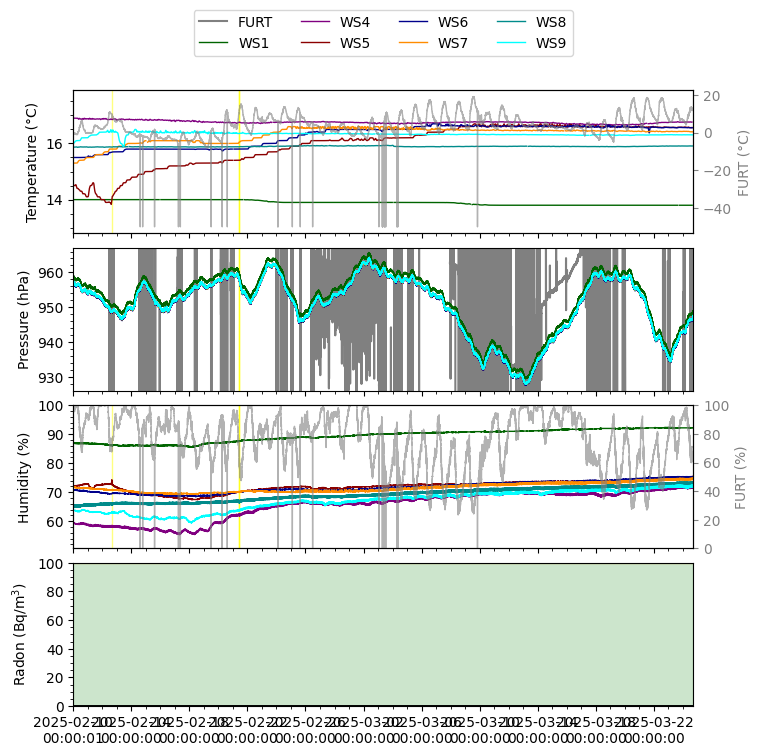

In [18]:
fig = __makeplot();

In [19]:
fig.savefig(config['path_to_figs']+f"html_wromy.png", format="png", dpi=150, bbox_inches='tight')

In [20]:
del fig